In [1]:
import nltk # need to insatll verison 3.8.1 for this code to work 
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import spacy

#from nrclex import NRCLex
# requiremnet to download necessary data for NRCLex run simply run python -m textblob.download_corpora
# or use the NLTK downloader to download the missing data: http://nltk.org/data.html


# Download required NLTK resources
try:
    nltk.download('punkt')
    nltk.download('punkt_tab')  # This is the specific missing resource
    nltk.download('averaged_perceptron_tagger')
    nltk.download('wordnet')
    nltk.download('omw-1.4')
except:
    pass

# necessary steps for NRCLex to run
import subprocess
try:
    subprocess.run(['python', '-m', 'textblob.download_corpora'])
except:
    pass

# finally importing it
from nrclex import NRCLex
# make sure to do !pip install openpyxl beforehand

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\daran\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\daran\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\daran\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\daran\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\daran\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\daran\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-d

In [2]:
# opening dataset
van_gogh_data = pd.read_excel('cleaned_van_gogh_letters.xlsx')

van_gogh_data.head()

,Letter,From,To,Location,Date,Original Text,Translation,Note 1,Note 2,Note 3,...,Note 119,Note 120,Note 121,Note 122,Note 123,Note 124,Note 125,Note 126,Note 127,Note 128
0,191,Vincent van Gogh,Theo van Gogh,The Hague,"between Thursday, 1 and Saturday, 3 December 1881","den Haag Dec 1881. Waarde Theo, Zoo als ge zie...","The Hague, Dec. 1881. My dear Theo, As you see...",Mauve the Strickers Regarding ’s plan to visit...,"F 63 / JH 920 (). See cat. Amsterdam 1999, p. ...",Mauve The boarding-house must therefore have b...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,554,Vincent van Gogh,Theo van Gogh,Antwerp,"on or about Friday, 22 January 1886","Waarde Theo, Een paar dagen heb ik nu ginder g...","My dear Theo, I’ve been painting there for a f...",It emerges from that Van Gogh painted a large ...,Vinck In the ‘Classical Statues’ class with :,See for this painting class: cat. Amsterdam 20...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,238,Vincent van Gogh,Theo van Gogh,The Hague,"Friday, 9 June 1882","Waarde Theo, Weinig dingen hebben in den laats...","My dear Theo, Few things have given me so much...",Sien father When exactly left is not known. On...,Means: ‘het ziekenhuis’ (the hospital).,Armand Cassagne Van Gogh might be referring he...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,361,Vincent van Gogh,Theo van Gogh,The Hague,"on or about Wednesday, 11 July 1883","Waarde Theo, Naar Uw brief had ik reeds min of...","My dear Theo, I had already been looking out f...",The exhibition at Galerie Georges Petit. At th...,Jules Dupré Rousseau Troyon There were four wo...,Constant Troyon Which particular painting of a...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,445,Vincent van Gogh,Theo van Gogh,Nuenen,"Wednesday, 30 April 1884","Waarde Theo, Hartelijk gefeliciteerd met Uw ve...","My dear Theo, Many happy returns of the day. I...",Theo was 27 on 1 May 1884.,"Boussod, Valadon & Cie Mr van Gogh This remark...","F 30 / JH 479 Most probably (), which is indee...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Cleaning the data

In [3]:
# only selecting letters sent by Van Gogh
letters = van_gogh_data[van_gogh_data['From'] == 'Vincent van Gogh']

In [4]:
letters["Translation"].isna().sum() # it appears that two letters have not been translated to English
# we will drop this before continuing our analysis 

2

In [5]:
letters = letters.dropna(subset=["Translation"])

In [6]:
# creating a copy of df to avoid modifying original 
sentiment_letters = letters.copy()

# Sentiment Analysis of All Letters 
## VADER

In [7]:
# initializing analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# applying sentiment analysis to all letters in English
sentiment_scores = sentiment_letters["Translation"].apply(sentiment_analyzer.polarity_scores)

# adding sentiment scores as new columns to our dataset
sentiment_letters['negative'] = [score["neg"] for score in sentiment_scores]
sentiment_letters['neutral'] = [score["neu"] for score in sentiment_scores]
sentiment_letters['positive'] = [score["pos"] for score in sentiment_scores]
sentiment_letters['compound'] = [score["compound"] for score in sentiment_scores] # combination of previously mentioned sentiment scores

# adding overall sentiment category: positive, neutral, negative
# if compound score >= 0.05 classified as positive, compound score <= -0.05, else neutral
sentiment_letters['sentiment'] = sentiment_letters['compound'].apply(
    lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral'))

# printing sentiment distribution
print("\nSentiment Distribution:")
print(sentiment_letters['sentiment'].value_counts())


Sentiment Distribution:
sentiment
Positive    789
Negative     27
Neutral       2
Name: count, dtype: int64


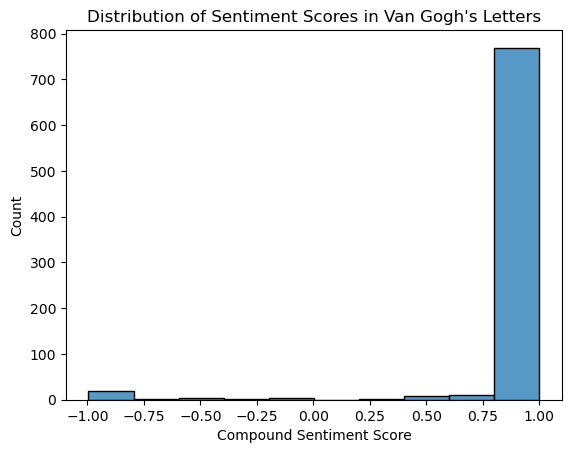

In [8]:
# distribution of compound sentiment scores
ax = sns.histplot(data= sentiment_letters, x='compound', bins=10)
ax.set_title('Distribution of Sentiment Scores in Van Gogh\'s Letters')
ax.set_xlabel('Compound Sentiment Score')
plt.show()

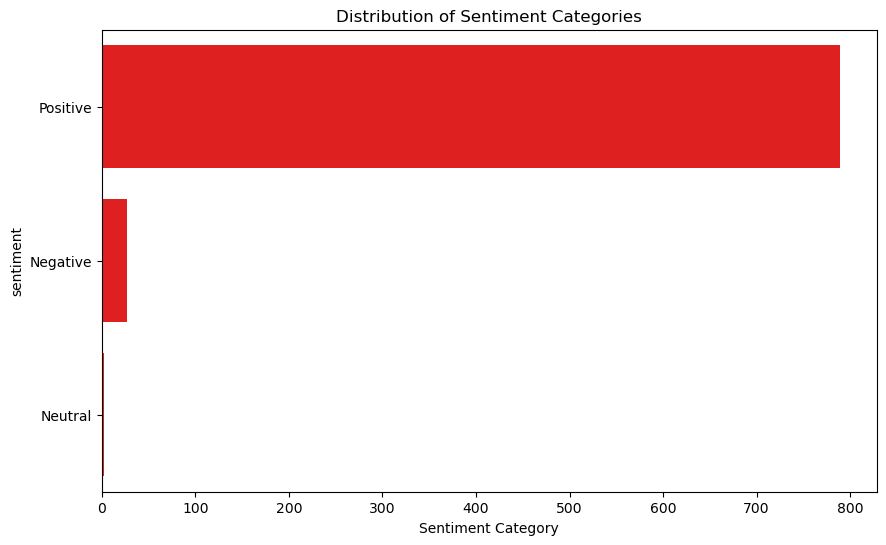

In [9]:
# Plot 2: Overall sentiment categories
sentiment_counts = sentiment_letters['sentiment'].value_counts()
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(sentiment_counts, ax=ax, orient = 'h', color = 'red')

#ax2 = sns.barplot(sentiment_counts, orient = "h", color='steelblue')
ax.set_title('Distribution of Sentiment Categories')
ax.set_xlabel('Sentiment Category')
plt.show()

In [12]:
# gathering letter with most negative score to test reliability of algorithm
most_negative_letter = sentiment_letters[sentiment_letters["compound"] == sentiment_letters["compound"].min()]

# displaying results
#print(f"Minimum compound score: {sentiment_letters["compound"].min()}")
print("\nMost negative letter(s):")
most_negative_letter["Translation"].values


Most negative letter(s):


array(['My dear Theo, You’re quite right to ask why I haven’t replied to you yet. I did indeed receive your letter with 150 francs enclosed. I began a letter to you, chiefly to thank you because you seemed to have understood my letter, and also to tell you that I only on 100 francs, but actually find it hard to manage on it as long as things don’t progress. But nevertheless, if it’s 150 francs, there’s a 50 francs windfall extra in so far as our agreement was only 100 francs, and if we’re only half good friends I wouldn’t want to accept more. However, I couldn’t finish that letter, and since then I’ve wanted to write to you but I haven’t been able to find the right words. Something has happened, Theo, which most of the people here know or suspect about — nor may ever know, so keep as silent as the grave about it — but which is terrible. To tell you everything I’d have to write a book — I can’t do that. has taken poison — in a moment of despair, when she’d spoken to her family and peopl

In [13]:
# gathering letter with most negative score to test reliability of algorithm
most_positive_letter = sentiment_letters[sentiment_letters["compound"] == sentiment_letters["compound"].max()]

# displaying results
#print(f"Minimum compound score: {sentiment_letters["compound"].min()}")
print("\nMost positive letter(s):")
most_positive_letter["Translation"].values


Most positive letter(s):


array(['Dordrecht, 28 February 1877 My dear Theo, Write again soon if you can find a moment, remain steadfast, be of good heart, and He shall strengthen thine heart. Wrote something for us last night which I enclose herewith, read it sometime. Last night I left the office at 1 o’clock and walked around the Grote Kerk again and then along the canals and past that old gate to the Nieuwe Kerk and then home. It had snowed and everything was so still, the only thing one saw was a little light here and there in one or two upstairs rooms and, in the snow, the black figure of the rattle-man. It was high tide, and the canals and boats looked dark against the snow. It can be so beautiful there by those churches. The sky was grey and foggy, and the moon shone faintly through it. Thought of you while I was walking, and upon arriving home I wrote what I’m sending you. It’s perhaps a time when one needs ‘the sound of a psalm of the past and a lamentation from the Cross’. Behold, I thought in the dea

## NRCLex
Going beyond the extent of the emotion (whether positive/negative) by detecting actual emotions Van Gogh expresses. While VADER looks at the intensity of emotion of each letter, NRCLex classifies text into specific emotion categories (joy, fear, anger, sadness, etc.)

In [10]:
# making lists to store emotion data
all_emotions = [] # storing all emotions detected
emotion_scores = [] # storing scores of all emotions
primary_emotions = [] # storing the primary emotion
secondary_emotions = [] # storing secondary emotion

# iterating over all letters
for text in sentiment_letters["Translation"]:
    emotion = NRCLex(text)
    emotions_dict = emotion.raw_emotion_scores    
    all_emotions.append(emotions_dict) # storing all emotions present
    total_emotional_words = sum(emotions_dict.values()) # calculating emotion scores (normalized)
    if total_emotional_words > 0: 
        scores = {emotion: count/total_emotional_words for emotion, count in emotions_dict.items()}
    else:
        scores = emotions_dict
    emotion_scores.append(scores)
        
# determining primary and secondary emotions
    if emotion_scores:
        sorted_emotions = sorted(scores.items(), key=lambda x: x[1], reverse=True) # sorting emotion scores by ascending order
        primary_emotions.append(sorted_emotions[0][0] if sorted_emotions else 'neutral') # adding primary emotions to list
        secondary_emotions.append(sorted_emotions[1][0] if len(sorted_emotions) > 1 else 'none') # adding secondary emotions to list
    else:
        primary_emotions.append('neutral') # if no primary emotion deteted setting it as neutral 
        secondary_emotions.append('none') # or none for secondary emotions (as no other main emotion was detected)

# adding emotion columns to dataset so we can make visualizations
sentiment_letters['emotion_scores_NRCLex'] = emotion_scores # emotion scores
sentiment_letters['primary_emotion'] = primary_emotions # primary emotion of each letter
sentiment_letters['secondary_emotion'] = secondary_emotions # secondary emotion of each letter
    
    

In [11]:
sentiment_letters.head(2) # looking at dataset now

,Letter,From,To,Location,Date,Original Text,Translation,Note 1,Note 2,Note 3,...,Note 127,Note 128,negative,neutral,positive,compound,sentiment,emotion_scores_NRCLex,primary_emotion,secondary_emotion
0,191,Vincent van Gogh,Theo van Gogh,The Hague,"between Thursday, 1 and Saturday, 3 December 1881","den Haag Dec 1881. Waarde Theo, Zoo als ge zie...","The Hague, Dec. 1881. My dear Theo, As you see...",Mauve the Strickers Regarding ’s plan to visit...,"F 63 / JH 920 (). See cat. Amsterdam 1999, p. ...",Mauve The boarding-house must therefore have b...,...,NaN,NaN,0.052,0.805,0.143,0.9937,Positive,"{'positive': 0.24242424242424243, 'fear': 0.02...",positive,negative
1,554,Vincent van Gogh,Theo van Gogh,Antwerp,"on or about Friday, 22 January 1886","Waarde Theo, Een paar dagen heb ik nu ginder g...","My dear Theo, I’ve been painting there for a f...",It emerges from that Van Gogh painted a large ...,Vinck In the ‘Classical Statues’ class with :,See for this painting class: cat. Amsterdam 20...,...,NaN,NaN,0.037,0.818,0.145,0.9950,Positive,"{'positive': 0.24358974358974358, 'negative': ...",positive,anticipation


In [12]:
sentiment_letters["primary_emotion"].value_counts()

primary_emotion
positive        781
anticipation     19
negative         11
trust             5
neutral           1
fear              1
Name: count, dtype: int64

In [13]:
sentiment_letters["secondary_emotion"].value_counts()

secondary_emotion
trust           352
anticipation    247
negative        129
joy              57
positive         30
none              2
sadness           1
Name: count, dtype: int64

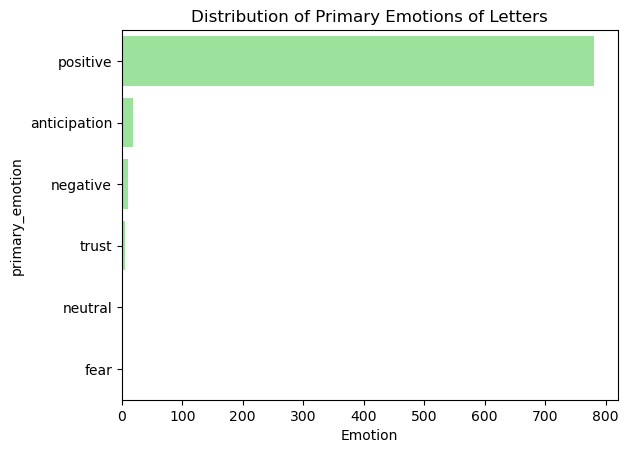

In [14]:
# plotting primary emotions of letters 
ax3 = sns.barplot(sentiment_letters['primary_emotion'].value_counts(), orient = "h", color = "lightgreen")
ax3.set_title('Distribution of Primary Emotions of Letters')
ax3.set_xlabel('Emotion')
plt.show()

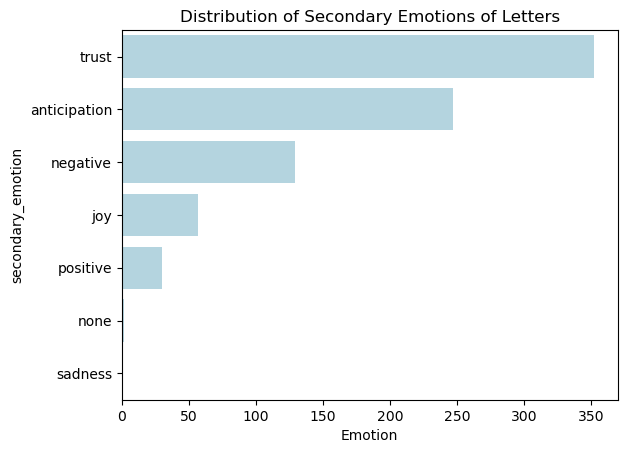

In [15]:
# plotting primary emotions of letters 
ax3 = sns.barplot(sentiment_letters['secondary_emotion'].value_counts(), orient = "h", color = "lightblue")#sentiment_counts.plot(kind='bar')
ax3.set_title('Distribution of Secondary Emotions of Letters')
ax3.set_xlabel('Emotion')
plt.show()

# Validation 
Checking whether the results of both algorithms are in accordance

In [16]:
# grouping NRCLex emotions into positive and negative
positive_emotions = ['positive','trust', 'anticipation']
negative_emotions = ['negative','fear']
neutral_emotions = ['neutral']

# calculating the extent both algorithms agree

total_letters = len(sentiment_letters) # total number of letters

# number of letters both algorithms labeled with positive emotions
positive_agreement = len(sentiment_letters[
    (sentiment_letters['sentiment'] == 'Positive') & 
    (sentiment_letters['primary_emotion'].isin(positive_emotions))
])

# number of letters both algorithms labeled with negative emotions
negative_agreement = len(sentiment_letters[
    (sentiment_letters['sentiment'] == 'Negative') & 
    (sentiment_letters['primary_emotion'].isin(negative_emotions))
])

# number of letters both algorithms labeled with neutral emotions
neutral_agreement = len(sentiment_letters[
    (sentiment_letters['sentiment'] == 'Neutral') & 
    (sentiment_letters['primary_emotion'].isin(neutral_emotions))
])

# putting it all together in a dictionary 
agreement_stats = {
        'positive_sentiment_positive_emotion': positive_agreement,
        'negative_sentiment_negative_emotion': negative_agreement,
        'neutral_agreement': neutral_agreement,
        'total_agreement': positive_agreement + negative_agreement + neutral_agreement,
        'total_agreement_pct': ((positive_agreement + negative_agreement + neutral_agreement)/total_letters) * 100,
        'total_disagreement': total_letters - (positive_agreement + negative_agreement + neutral_agreement),
        'total_disagreement_pct': 100 - ((positive_agreement + negative_agreement + neutral_agreement)/total_letters) * 100
    }
agreement_stats

{'positive_sentiment_positive_emotion': 784,
 'negative_sentiment_negative_emotion': 6,
 'neutral_agreement': 1,
 'total_agreement': 791,
 'total_agreement_pct': 96.69926650366747,
 'total_disagreement': 27,
 'total_disagreement_pct': 3.3007334963325263}

# Performing Entity Recognition 
Now that we have explored Van Gogh's overall sentiments and emotions in general, we will explore how he felt towards particular entities. For this we will use the spacy package that is able to extract entities mentioned in text data. The algorithm detects and classifies entitites that are people, organizations, geographical places, etc. For a clearer description check [this](https://towardsdatascience.com/named-entity-recognition-ner-using-spacy-nlp-part-4-28da2ece57c6#:~:text=Text%20Processing%20using%20spaCy%20%7C%20NLP%20Library&text=Named%20Entity%20Recognition%20NER%20works,values%2C%20percentage%2C%20codes%20etc.). We will first define the most commonly mentioned entities.

In [17]:
# necessary to do to be able to run algorithm
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    import subprocess
    subprocess.run(['python', '-m', 'spacy', 'download', 'en_core_web_sm'])
    nlp = spacy.load('en_core_web_sm')

# initializes counters for entity discovery
entity_counter = Counter()
entity_types = defaultdict(set)

# iterating over all letters 
for text in sentiment_letters['Translation']:
    doc = nlp(text)
    for ent in doc.ents: # counting how many times each entity appears 
        entity_counter[ent.text] += 1
        entity_types[ent.text].add(ent.label_)

# filtering frequent entities that appear at least 5 times in the letters 
min_frequency = 5
frequent_entities = { # creating dictionaries for each entity
    entity: {
        'count': count, # how many times it appears in the letters
        'types': list(entity_types[entity]) # what type of entity it is 
    }
    for entity, count in entity_counter.items()
    if count >= min_frequency
}

In [74]:
frequent_entities # output 

{'The Hague': {'count': 174, 'types': ['GPE']},
 'Theo': {'count': 951, 'types': ['PERSON', 'ORG']},
 'last Sunday': {'count': 22, 'types': ['DATE']},
 'Etten': {'count': 37, 'types': ['GPE', 'PRODUCT', 'ORG']},
 'a few days': {'count': 64, 'types': ['DATE']},
 'Mauve': {'count': 64, 'types': ['PRODUCT', 'PERSON', 'LOC', 'ORG']},
 'first': {'count': 726, 'types': ['ORDINAL']},
 'Het Heike': {'count': 15, 'types': ['PERSON', 'FAC']},
 '30 guilders': {'count': 6, 'types': ['MONEY']},
 '100 francs': {'count': 42, 'types': ['MONEY']},
 'M.': {'count': 6, 'types': ['PERSON', 'NORP']},
 'Amsterdam': {'count': 131, 'types': ['GPE']},
 'the spring': {'count': 33, 'types': ['DATE']},
 'Vincent': {'count': 604, 'types': ['GPE', 'PERSON']},
 'one': {'count': 1144, 'types': ['CARDINAL']},
 'Monday': {'count': 29, 'types': ['DATE']},
 'American': {'count': 11, 'types': ['NORP']},
 'Paris': {'count': 555, 'types': ['GPE']},
 '10 guilders': {'count': 23, 'types': ['MONEY']},
 'about one': {'count': 2

As we can see a lot of the entities found are not that interesting, especially does from the CARDINAL and ORDINAL type since they are just numbers that are either ordinal or do not fall on any other category, so they will be filtered out. 

# Sentiment Analysis Individual Entities and Nouns
## Looking at sentiments of main entities 

In [32]:
# Setting up necessary analyzers
nlp = spacy.load('en_core_web_sm')
analyzer = SentimentIntensityAnalyzer()

# Setting up default dictionaries to keep track of each entity's sentiment scores and frequencies
entity_sentiments = defaultdict(list)  # Missing values default to []
entity_frequencies = defaultdict(int)  # Missing values default to 0

# Going through all letters
for letter in sentiment_letters['Translation']:
    doc = nlp(letter)  # Tokenize the text into a SpaCy Doc object

    # Going through all sentences in each letter
    for sent in doc.sents:  # Iterating over each sentence
        sentiment = analyzer.polarity_scores(sent.text)['compound']  # Get compound sentiment score for the sentence

        # Iterating over each entity in the sentence
        for ent in sent.ents:  # Extracting named entities
            if ent.label_ not in ['CARDINAL', 'ORDINAL']:  # Exclude CARDINAL and ORDINAL entities
                entity_text = ent.text  
                entity_frequencies[entity_text] += 1  # Increment frequency count
                entity_sentiments[entity_text].append(sentiment)  # Append sentiment score for this entity

# Creating a dictionary that combines entity_sentiments and entity_frequencies
entity_analysis = {
    entity: {
        'frequency': freq,
        'all_sentiments': entity_sentiments[entity],
        'avg_sentiment': sum(entity_sentiments[entity]) / len(entity_sentiments[entity]),
        'min_sentiment': min(entity_sentiments[entity]),
        'max_sentiment': max(entity_sentiments[entity]),
        'sentiment_variance': sum((x - sum(entity_sentiments[entity]) / len(entity_sentiments[entity]))**2
                                  for x in entity_sentiments[entity]) / len(entity_sentiments[entity])
    }
    for entity, freq in entity_frequencies.items()
}

In [67]:
# only selecting words that were mentioned at least 100 times
filtered_entities = {noun: data for noun, data in entity_analysis.items() if data['frequency'] >= 100}

# sorting the filtered entities by frequency in descending order
sorted_entities = sorted(filtered_entities.items(), key=lambda x: x[1]['frequency'], reverse=True)

# building the final summary dictionary
summary_entities = {}
for entity, data in sorted_entities:
    sentiment = data['avg_sentiment']
    variance = data['sentiment_variance']
    sentiment_label = 'positive' if sentiment > 0.05 else 'negative' if sentiment < -0.05 else 'neutral'

    summary_entities[entity] = {
        'frequency': data['frequency'],
        'sentiment': sentiment_label,
        'average_sentiment': round(data['avg_sentiment'], 2),
        'tone_variance': round(variance, 2),
        'all_sentiments': data['all_sentiments'],
        'min_sentiment':round(data['min_sentiment'], 2),
        'max_sentiment':round(data['max_sentiment'], 2)
    }

entity_sentiment_df = pd.DataFrame.from_dict(summary_entities, orient='index')
entity_sentiment_df.head()

,frequency,sentiment,average_sentiment,tone_variance,all_sentiments,min_sentiment,max_sentiment
Theo,951,positive,0.44,0.14,"[0.3818, 0.0, 0.3818, 0.8508, 0.8109, 0.6808, ...",-0.92,0.98
Vincent,604,positive,0.25,0.10,"[0.2732, 0.4404, 0.5598, 0.4404, 0.4404, 0.0, ...",-0.95,0.99
Paris,555,positive,0.23,0.17,"[0.6908, 0.0, 0.3182, -0.1027, 0.2732, -0.7003...",-0.93,0.94
today,337,positive,0.22,0.17,"[0.235, 0.235, 0.7003, 0.6115, 0.4404, 0.5346,...",-0.85,0.95
London,187,positive,0.26,0.17,"[0.7501, -0.3804, -0.3804, 0.0, -0.1027, 0.0, ...",-0.90,0.93


C:\Users\daran\AppData\Local\Temp\ipykernel_20444\1252098425.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_entities, x='frequency', y='Entity', palette='viridis')


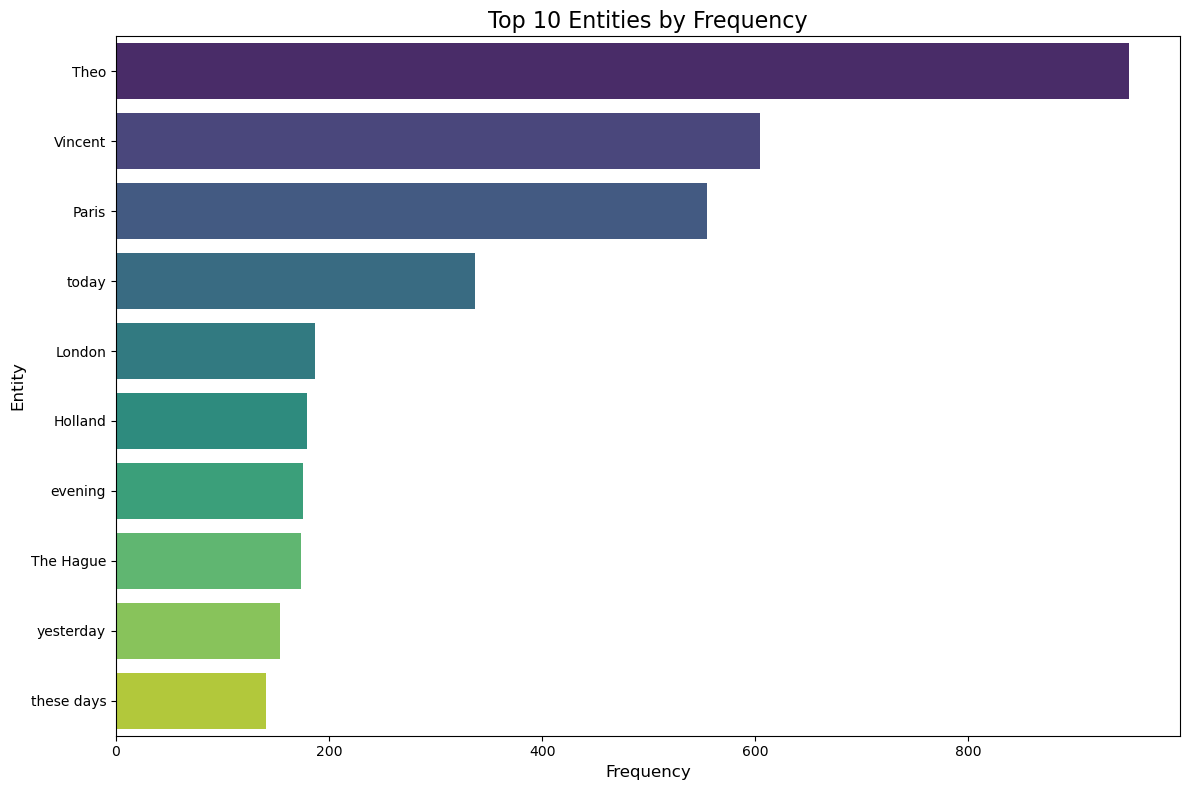

In [68]:
# resetting the index 
entity_sentiment_df = entity_sentiment_df.reset_index()

# making a new column called Entity for each entity 
entity_sentiment_df = entity_sentiment_df.rename(columns={'index': 'Entity'})  # If 'index' was the name of your entity column

# plotting top 10 Entities by Frequency
plt.figure(figsize=(12, 8))

# selecting top 10 columns based on frequency
top_entities = entity_sentiment_df.nlargest(10, 'frequency')

# Use barplot to display the top entities by frequency
sns.barplot(data=top_entities, x='frequency', y='Entity', palette='viridis')

plt.title('Top 10 Entities by Frequency', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Entity', fontsize=12)
plt.tight_layout()
plt.show()

,Noun,frequency,sentiment,average_sentiment,tone_variance,all_sentiments,min_sentiment,max_sentiment
0,thing,3329,positive,0.23,0.22,"[0.3919, 0.6444, 0.0, 0.1027, 0.0, 0.8508, 0.1...",-0.96,0.99
1,time,2470,positive,0.18,0.20,"[-0.1531, 0.8957, 0.0, 0.875, 0.2732, -0.4767,...",-0.96,0.98
2,day,1856,positive,0.20,0.21,"[0.0, 0.0, 0.3818, 0.3321, 0.743, 0.0, 0.3818,...",-0.98,0.99
3,work,1602,positive,0.26,0.21,"[0.0, -0.8663, 0.8519, 0.7501, 0.7876, 0.3612,...",-0.95,0.99
4,painting,1582,positive,0.22,0.19,"[-0.1531, -0.0258, 0.4404, 0.6908, 0.6361, 0.2...",-0.94,0.96
5,way,1436,positive,0.19,0.21,"[0.0, 0.0, 0.875, 0.8338, -0.8663, 0.6908, -0....",-0.93,0.99
6,letter,1405,positive,0.31,0.16,"[0.7783, 0.0, 0.0, 0.6808, 0.6124, 0.101, 0.62...",-0.93,0.98
7,people,1307,positive,0.20,0.23,"[0.0, 0.4404, 0.7501, 0.2732, 0.8639, 0.7939, ...",-0.98,0.99
8,life,1206,positive,0.21,0.27,"[0.2732, 0.235, 0.4404, 0.8221, 0.9017, 0.3612...",-0.98,0.99
9,drawing,1156,positive,0.21,0.15,"[0.6486, -0.8663, 0.7458, 0.0, 0.0, -0.1027, 0...",-0.93,0.96


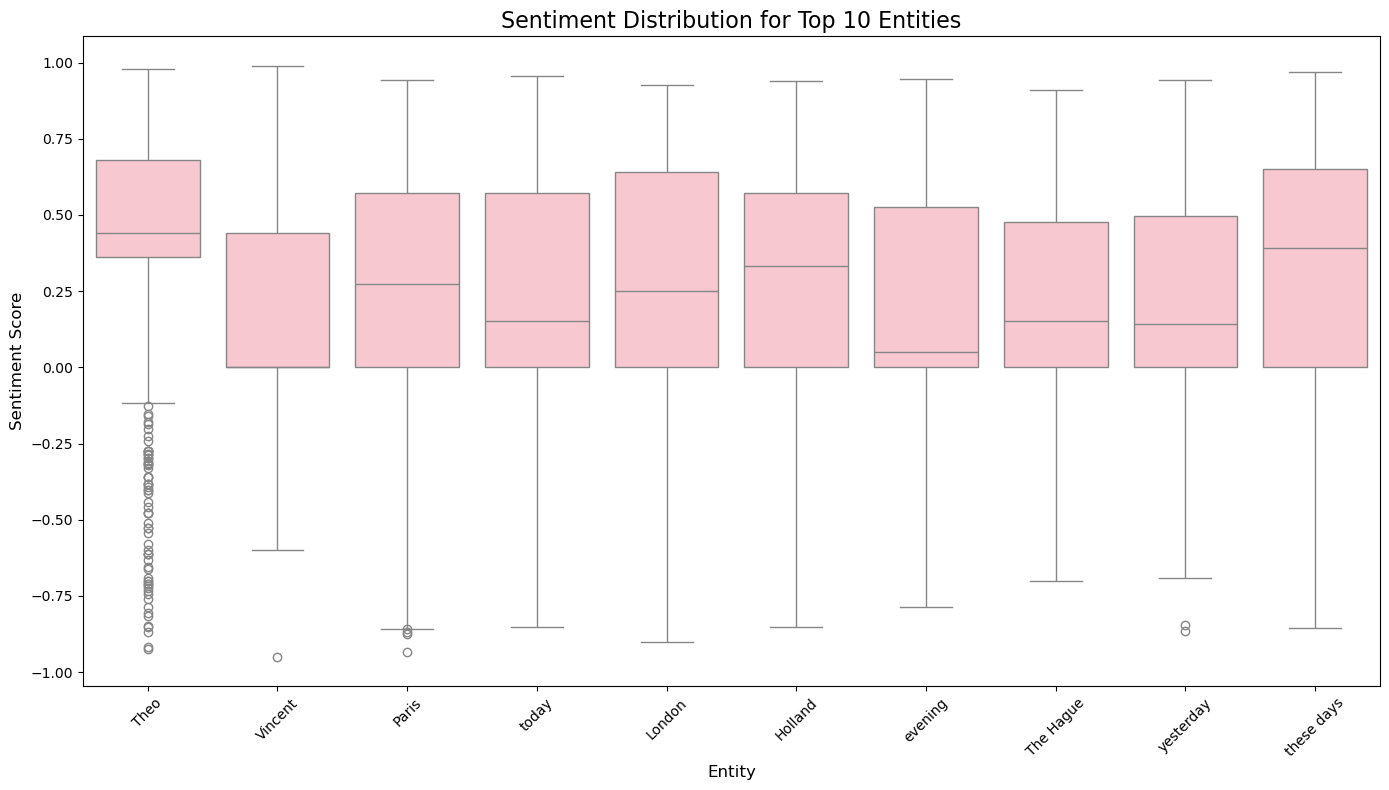

In [69]:
# Create a new DataFrame that will have 'Entity' and a single row per sentiment score
expanded_df = top_entities.explode('all_sentiments')

# Plot the violin plot
plt.figure(figsize=(14, 8))
sns.boxplot(data=expanded_df, x='Entity', y='all_sentiments', color='pink')
plt.title('Sentiment Distribution for Top 10 Entities', fontsize=16)
plt.xlabel('Entity', fontsize=12)
plt.ylabel('Sentiment Score', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

## looking at most common nouns and sentiment towards them


In [51]:
# setting up necessary analyzers
nlp = spacy.load('en_core_web_sm')
analyzer = SentimentIntensityAnalyzer()

# setting up default dictionaries to keep track of each nouns sentiment scores and frequencies 
# default dictionaries are used to avoid handling cases where a key does not already exist in the dictionary
noun_sentiments = defaultdict(list) # missing values as [] 
noun_frequencies = defaultdict(int) # 

# going through all letters 
for letter in sentiment_letters['Translation']:
    doc = nlp(letter) # needed for spacy to tokenize the text in such a way it becomes a DOC object 

    # going through all sentences in each letter 
    for sent in doc.sents: # doc.sents in spacy is used to iterate over each sentence in each letter
        sentiment = analyzer.polarity_scores(sent.text)['compound'] #get compound sentiment scores for each sentence 

        # iterating over each word/token 
        # extracting nouns, lemmatizing (so words like paintings and painting) get grouped together, and finding frequency of each word  
        for token in sent:
            if token.pos_ in ['NOUN', 'PROPN']: # spacy uses part-of-speech tagging to classify words
                lemma = token.lemma_.lower() # changing all words to lowercase 
                noun_frequencies[lemma] += 1 # adding each noun as a 
                noun_sentiments[lemma].append(sentiment) 

# creating a dictionary that combines noun_sentiments and noun_frequencies   
noun_analysis = {
    noun: {
        'frequency': freq,
        'avg_sentiment': sum(noun_sentiments[noun]) / len(noun_sentiments[noun]),
        'all_sentiments': noun_sentiments[noun],
        'min_sentiment': min(noun_sentiments[noun]),
        'max_sentiment': max(noun_sentiments[noun]),
        'sentiment_variance': sum((x - sum(noun_sentiments[noun])/len(noun_sentiments[noun]))**2 
                               for x in noun_sentiments[noun]) / len(noun_sentiments[noun])
    }
    for noun, freq in noun_frequencies.items()
}

In [70]:
# only selecting words that were mentioned at least 100 times
filtered_nouns = {noun: data for noun, data in noun_analysis.items() if data['frequency'] >= 100}

# sorting the filtered nouns by frequency in descending order
sorted_nouns = sorted(filtered_nouns.items(), key=lambda x: x[1]['frequency'], reverse=True)

# building the final summary dictionary
summary_nouns = {}
for noun, data in sorted_nouns:
    sentiment = data['avg_sentiment']
    variance = data['sentiment_variance']
    sentiment_label = 'positive' if sentiment > 0.05 else 'negative' if sentiment < -0.05 else 'neutral'

    summary_nouns[noun] = {
        'frequency': data['frequency'],
        'sentiment': sentiment_label,
        'average_sentiment': round(data['avg_sentiment'], 2),
        'tone_variance': round(variance, 2),
        'all_sentiments': data['all_sentiments'],
        'min_sentiment':round(data['min_sentiment'], 2),
        'max_sentiment':round(data['max_sentiment'], 2)
    }

noun_sentiment_df = pd.DataFrame.from_dict(summary_nouns, orient='index')
noun_sentiment_df.head()

,frequency,sentiment,average_sentiment,tone_variance,all_sentiments,min_sentiment,max_sentiment
thing,3329,positive,0.23,0.22,"[0.3919, 0.6444, 0.0, 0.1027, 0.0, 0.8508, 0.1...",-0.96,0.99
time,2470,positive,0.18,0.20,"[-0.1531, 0.8957, 0.0, 0.875, 0.2732, -0.4767,...",-0.96,0.98
day,1856,positive,0.20,0.21,"[0.0, 0.0, 0.3818, 0.3321, 0.743, 0.0, 0.3818,...",-0.98,0.99
work,1602,positive,0.26,0.21,"[0.0, -0.8663, 0.8519, 0.7501, 0.7876, 0.3612,...",-0.95,0.99
painting,1582,positive,0.22,0.19,"[-0.1531, -0.0258, 0.4404, 0.6908, 0.6361, 0.2...",-0.94,0.96


C:\Users\daran\AppData\Local\Temp\ipykernel_20444\826840985.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_nouns, x='frequency', y='Noun', palette='viridis')


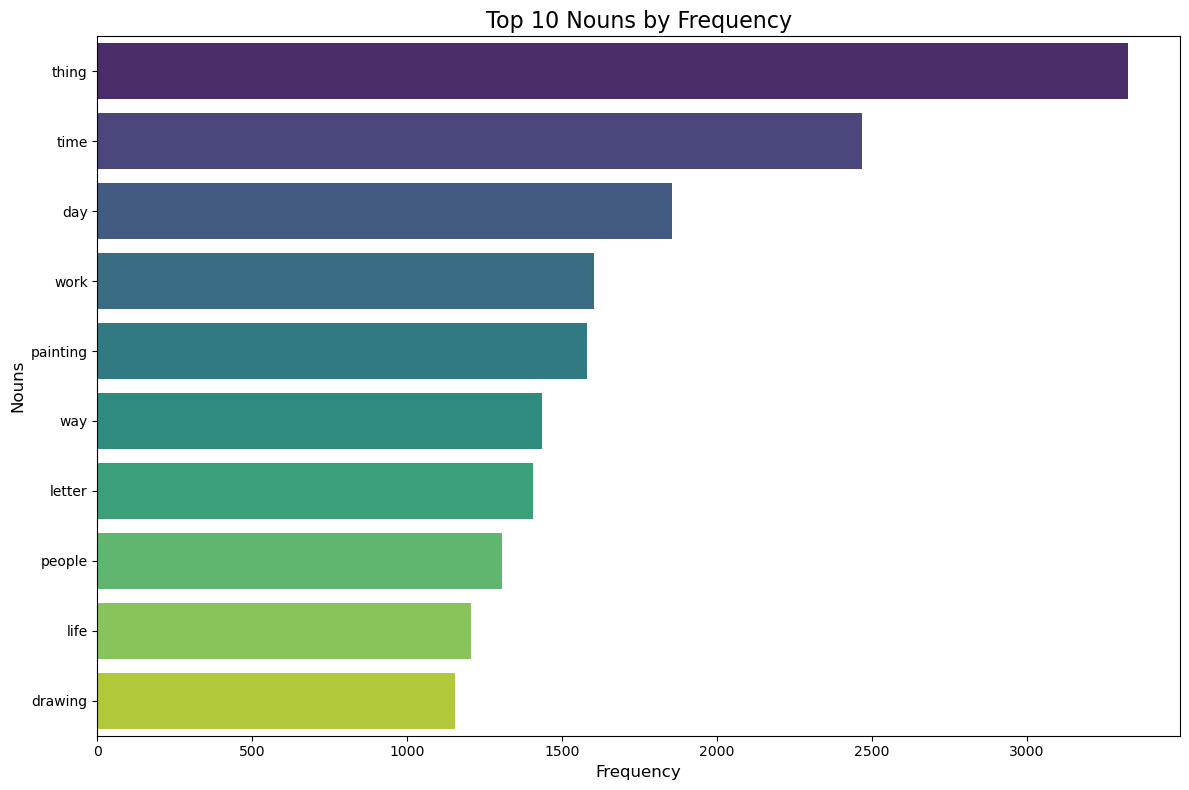

In [71]:
# resetting the index 
noun_sentiment_df = noun_sentiment_df.reset_index()

# making a new column called Entity for each entity 
noun_sentiment_df = noun_sentiment_df.rename(columns={'index': 'Noun'})  # If 'index' was the name of your entity column

# plotting top 10 Entities by Frequency
plt.figure(figsize=(12, 8))

# selecting top 10 columns based on frequency
top_nouns = noun_sentiment_df.nlargest(10, 'frequency')

# Use barplot to display the top entities by frequency
sns.barplot(data=top_nouns, x='frequency', y='Noun', palette='viridis')

plt.title('Top 10 Nouns by Frequency', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Nouns', fontsize=12)
plt.tight_layout()
plt.show()

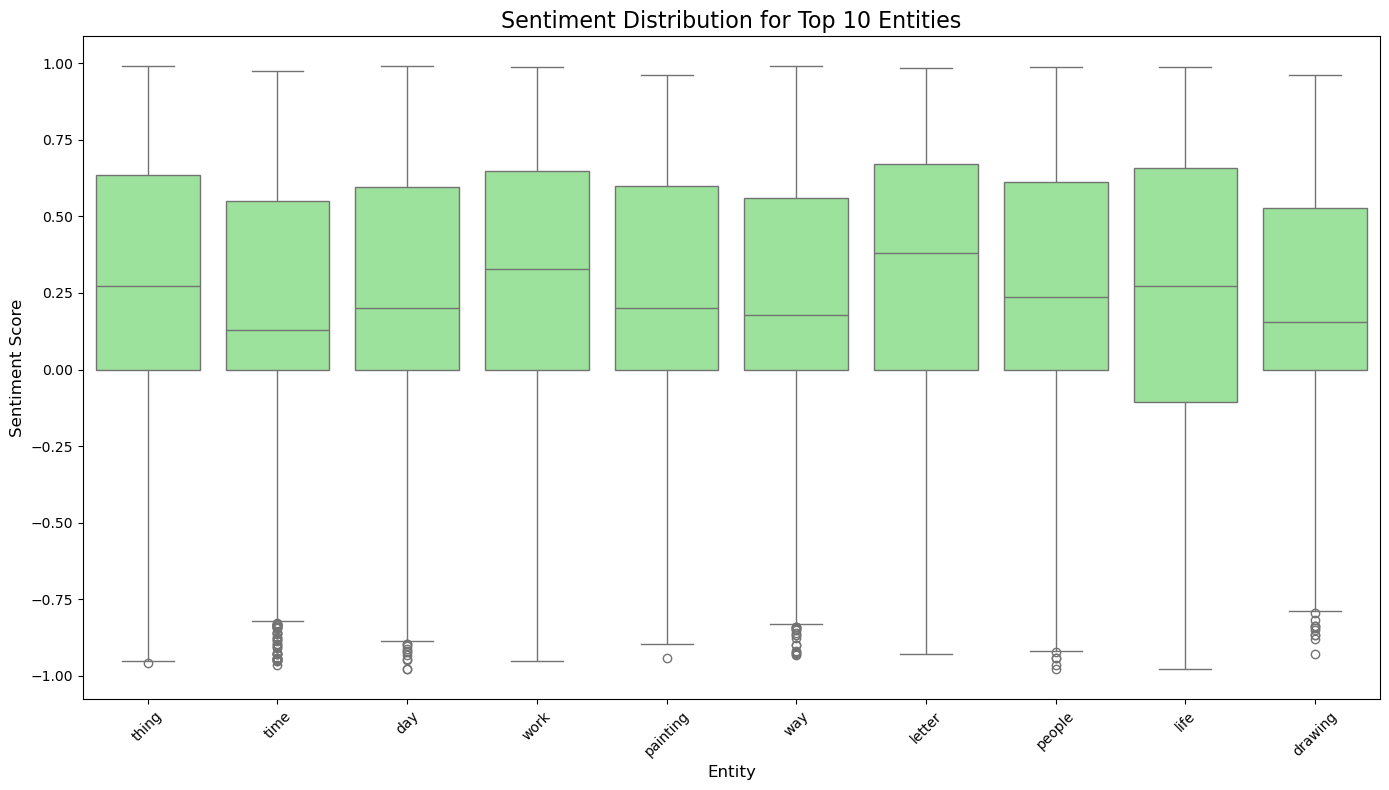

In [76]:
# Create a new DataFrame that will have 'Entity' and a single row per sentiment score
expanded_noun_df = top_nouns.explode('all_sentiments')

# Plot the violin plot
plt.figure(figsize=(14, 8))
sns.boxplot(data=expanded_noun_df, x='Noun', y='all_sentiments', color='lightgreen')
plt.title('Sentiment Distribution for Top 10 Entities', fontsize=16)
plt.xlabel('Entity', fontsize=12)
plt.ylabel('Sentiment Score', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()